In [2]:
# import packages
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# The Gaia phase-space snail

Following Tremaine et al. (2023), I animate the 1D vertical oscillations of stars in a disk, modeled by a self-gravitating isothermal slab.

Eqs. 4-8 describe the dynamics of the slab, and Eq. 1 describes the time evolution of any density perturbation.

# Slab dynamics

Here, I write down Eqs. 4-8 from Tremaine et al. (2023), which includes the dynamics of the slab and the definitions of our angle-action coordinates.

First, I'll simulate just one star at an arbitrary $(\theta,J)$. Eventually, I'll sample ~10,000-100,000 stars from the distribution function Eq. 6.

## Vertical oscillation

Suppose a perturbation at time $t_i$ changes the distribution function $f$ by amplitude $f_0(J)$. Furthermore, for simplicity, only consider the perturbation's m=1 Fourier component in $\theta$. Then this perturbation evolves as:
$$f_0(J) \cos\left[\theta - \Omega(J)(t-t_i)-\theta_i\right] $$

In [24]:
## Omega definitions
def Omega_big(J, Omega_small=1/np.sqrt(2)):
    '''
    See paragraph after Eq. 8 of Tremaine et al. (2023); orbital frequency
    when the action J >> sigma*z_0. Omega_small is the limit of Omega
    when J << sigma*z_0.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    return coeff * J**(-1/3)

def Omega_big_deriv(J, Omega_small=1/np.sqrt(2)):
    '''
    Derivative of the function Omega_big wrt J.
    
    '''
    
    coeff = (Omega_small**2 * np.pi)**2
    coeff = (coeff / 3)**(1/3)
    
    return coeff * (-1/3) * J**(-4/3)

def Omega_interm(J, Omega_small=1/np.sqrt(2)):
    '''
    The "intermediate" expression for Omega: it's a cubic polynomial
    interpolation between the low-J and high-J regimes for Omega
    (represented by Omega_small and Omega_big, respectively).
    
    The polynomial is aJ^3 + bJ^2 + cJ + d. (The boundary conditions,
    algebra, etc. needed to get the coefficients are in my notes.)
    
    '''
    
    x_2 = 10*np.sqrt(2)*Omega_small # 10 times sigma*z_0; we assume that this is 
                                    # the minimum J corresponding to J >> sigma*z_0
    y_2 = Omega_big(x_2)
    
    a = -2*(y_2 - Omega_small)/(x_2**3) + Omega_big_deriv(x_2)/(x_2**2)
    b = 3*(y_2 - Omega_small)/(x_2**2) - Omega_big_deriv(x_2)/x_2
    c = 0
    d = Omega_small
    
    return a*J**3 + b*J**2 + c*J + d
    

def Omega(J):
    '''
    Eq. 8 of Tremaine et al. (2023); orbital frequency. Refer to notes on 
    notation and definitions (e.g., definition of Omega_small, setting
    z_0 = 0).
    
    '''
    
    Omega_small = 1 / np.sqrt(2) # norm'd s.t. sigma*z_0=1
    
    # 10 times sigma*z_0; we assume that this is 
    # the minimum J corresponding to J >> sigma*z_0
    if (J < 10*np.sqrt(2)*Omega_small):
        return Omega_interm(J, Omega_small)
    else:
        return Omega_big(J, Omega_small)
    
    


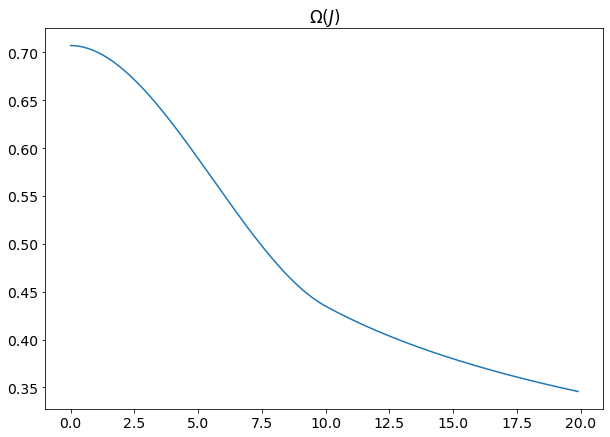

In [32]:
xs = np.arange(0, 20, 1e-1)
# vectorized version of Omega, needed since Omega performs boolean ops
Omega_vect = np.vectorize(Omega) 

plt.plot(xs, Omega_vect(xs))
plt.title("$\Omega(J)$")
plt.show()

In [57]:
def delta_f(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a perturbation
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

## 2D animation

Adapting my code from my "Phase Mixing Plots" notebook.

In [85]:
# time range
tmin = 0
tmax = 20
tstep = 0.1
ts = np.arange(tmin, tmax, tstep)

# phase space (angle vs. action) grid
theta_min = 0
theta_max = 2*np.pi
J_min = 0
J_max = 15
step = 0.1

thetas = np.arange(theta_min, theta_max, theta_max/50)
Js = np.arange(J_min, J_max, step)
thetas, Js = np.meshgrid(thetas, Js)

In [86]:
# need to vectorize since delta_f (implicitly) uses boolean ops
delta_f_vectorized = np.vectorize(delta_f)
Z = delta_f_vectorized(thetas, Js, 0.)

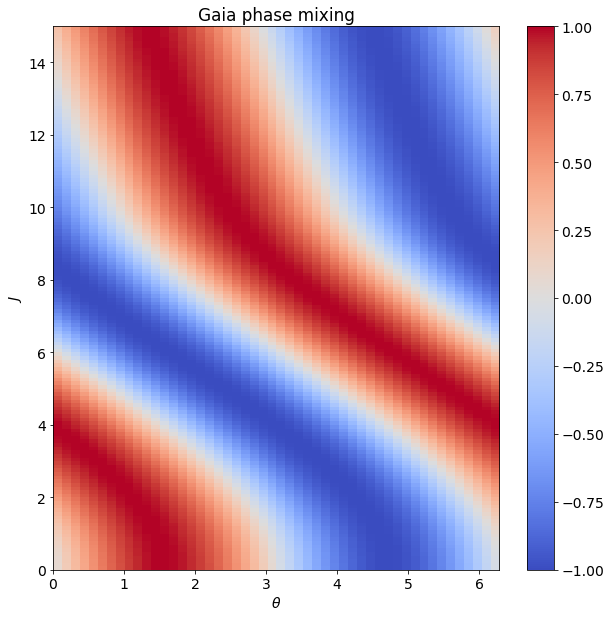

In [87]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

# initialize the color bar
im = ax.imshow(delta_f_vectorized(thetas, Js, t=0), cmap=cm.coolwarm, animated=True)
fig.colorbar(im)
plt.title('Gaia phase mixing')

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

# make each frame
for t in ts:
    Z = delta_f_vectorized(thetas, Js, t)
    delta_n = np.sum(Z[:, 0]) # integrate over J
    delta_n_array.append(delta_n)
    
    im = ax.imshow(Z, cmap=cm.coolwarm, origin='lower', \
                   extent=(theta_min, theta_max, J_min, J_max), animated=True, \
                   aspect='auto') # automatically set plot's aspect ratio
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$J$')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True)

# To save the animation, use e.g.
#
ani.save("Gaia_phase_mixing_temp.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("phase_mixing.mp4", writer=writer)

# plt.show()

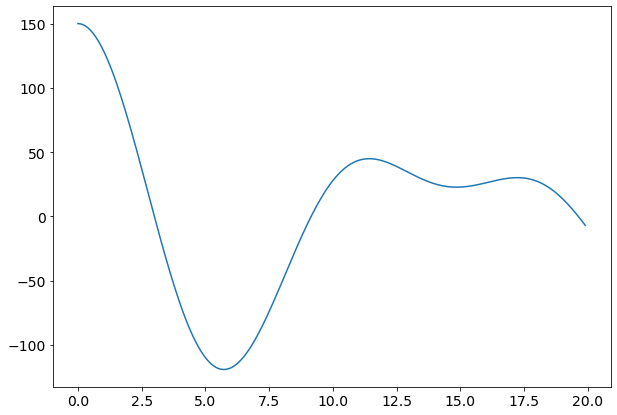

In [88]:
# density at theta=0
plt.plot(ts, delta_n_array)